
##  Example useage of Profile object.

### Overview

INDEXED type class for storing data from a CTD Profile (or similar
down and up observations). The structure of the class is based around having
discrete profile locations with independent depth dimensions and coords. 
The class dataset should contain two dimensions:

    > id_dim      :: The profiles dimension. Each element of this dimension
                 contains data (e.g. cast) for an individual location.
    > z_dim   :: The dimension for depth levels. A profile object does not
                 need to have shared depths, so NaNs might be used to
                 pad any depth array.

Alongside these dimensions, the following minimal coordinates should also
be available:

    > longitude (id_dim)   :: 1D array of longitudes, one for each id_dim
    > latitude  (id_dim)   :: 1D array of latitudes, one for each id_dim
    > time      (id_dim)   :: 1D array of times, one for each id_dim
    > depth     (id_dim, z_dim)  :: 2D array of depths, with different depth
                                levels being provided for each profile.
                                Note that these depth levels need to be
                                stored in a 2D array, so NaNs can be used
                                to pad out profiles with shallower depths.
    > id_name   (id_dim)   :: [Optional] Name of id_dim/case or id_dim number.

## Introduction to Profile and ProfileAnalysis

Below is a description of the available example scripts for this class as well
as an overview of validation using `Profile` and `ProfileAnalysis`.

### Example Scripts

Please see `COAsT/example_scripts/notesbooks/runnable_notebooks/profile_validation/*.ipynb` and `COAsT/example_scripts/profile_validation/*.py` for some notebooks and equivalent scripts which
demonstrate how to use the Profile and ProfileAnalysis classes for model
validation. 

1. `analysis_preprocess_en4.py` : If you're using EN4 data, this kind of script
might be your first step for analysis.

2. `analysis_extract_and_compare.py`: This script shows you how to extract
the nearest model profiles, compare them with EN4 observations and get errors
throughout the vertical dimension and averaged in surface and bottom zones

3. `analysis_extract_and_compare_single_process.py`: This script does the same
as number 2. However, it is modified slightly to take a command line argument
which helps it figure out which dates to analyse. This means that this script
can act as a template for `jug` type parallel processing on, e.g. JASMIN.

4. `analysis_mask_means.py`: This script demonstrates how to use boolean masks
to obtain regional averages of profiles and errors.

5. `analysis_average_into_grid_boxes.py`: This script demonstrates how to 
average the data inside a `Profile` object into regular grid boxes and 
seasonal climatologies.

## Load and preprocess profile and model data

Start by loading python packages


In [1]:
import coast
from os import path
import numpy as np
import matplotlib.pyplot as plt

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


We can create a new Profile object easily:

In [2]:
profile = coast.Profile()

Currently, this object is empty, and contains no dataset. There are some
reading routines currently available in Profile for reading EN4 or WOD data
files. These can be used to easily read data into your new profile object:


In [4]:
# Read WOD data into profile object
fn_prof = path.join("../../../../example_files","WOD_example_ragged_standard_level.nc")
profile.read_wod( fn_prof )

# Read EN4 data into profile object (OVERWRITES DATASET)
fn_prof = path.join("../../../../example_files", "coast_example_en4_201008.nc")
fn_cfg_prof = path.join("../../../../config","example_en4_profiles.json")
profile = coast.Profile(config=fn_cfg_prof)
profile.read_en4( fn_prof )

../../../../config/example_en4_profiles.json


Alternatively, you can pass an `xarray.dataset` straight to Profile:
```
profile = coast.Profile( dataset = your_dataset, config = config_file [opt] )
```

If you are using EN4 data, you can use the `process_en4()` routine to apply
quality control flags to the data (replacing with NaNs):

In [5]:
processed_profile = profile.process_en4()
profile = processed_profile

We can do some simple spatial and temporal manipulations of this data:

In [6]:
# Cut out a geographical box
profile = profile.subset_indices_lonlat_box(lonbounds = [-15, 15],
                                            latbounds = [45, 65])

# Cut out a time window
profile = profile.time_slice( date0 = np.datetime64('2010-01-01'), date1 = np.datetime64("2010-01-20"))

### Inspect profile locations
Have a look inside the `profile.py` class to see what it can do

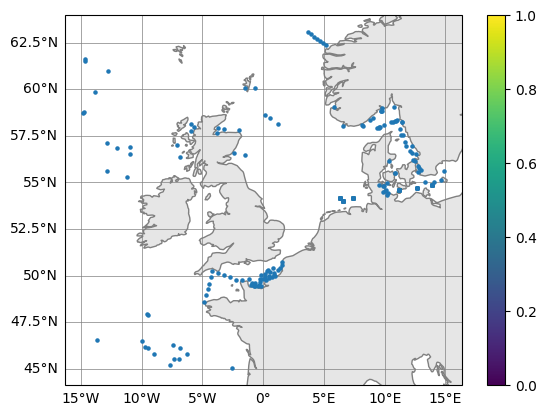

(<Figure size 640x480 with 2 Axes>, <GeoAxes: >)

In [7]:
profile.plot_map()

### Direct Model comparison using obs_operator() method

There are a number of routines available for interpolating in the horizontal,
vertical and in time to do direct comparisons of model and profile data.
`Profile.obs_operator` will do a nearest neighbour spatial interpolation of
the data in a `Gridded` object to profile latitudes/longitudes. It will also
do a custom time interpolation.

#### First load some model data:

In [10]:
root = "./"
# And by defining some file paths
dn_files = root + "../../../../example_files/"
fn_nemo_dat = path.join(dn_files, "coast_example_nemo_data.nc")
fn_nemo_dom = path.join(dn_files, "coast_example_nemo_domain.nc")
fn_nemo_config = path.join(root, "../../../../config/example_nemo_grid_t.json")

# Create gridded object:
nemo = coast.Gridded(fn_nemo_dat, fn_nemo_dom, multiple=True, config=fn_nemo_config)

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time_counter" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [12]:
nemo.dataset

<xarray.Dataset>
Dimensions:              (z_dim: 51, axis_nbounds: 2, t_dim: 7, y_dim: 375,
                          x_dim: 297)
Coordinates:
  * time                 (t_dim) datetime64[ns] 2007-01-01T11:58:56 ... 2007-...
    longitude            (y_dim, x_dim) float32 ...
    latitude             (y_dim, x_dim) float32 ...
    depth_0              (z_dim, y_dim, x_dim) float32 0.5 0.5 0.5 ... 50.5 50.5
Dimensions without coordinates: z_dim, axis_nbounds, t_dim, y_dim, x_dim
Data variables:
    deptht_bounds        (z_dim, axis_nbounds) float32 dask.array<chunksize=(51, 2), meta=np.ndarray>
    ssh                  (t_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 375, 297), meta=np.ndarray>
    time_counter_bounds  (t_dim, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_instant         (t_dim) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    temperature          (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 26, 188, 149), meta=np.ndarray>
    bathymetry           (y_dim, x_dim) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    e1                   (y_dim, x_dim) float32 ...
    e2                   (y_dim, x_dim) float32 ...
    e3_0                 (z_dim, y_dim, x_dim) float32 ...
    bottom_level         (y_dim, x_dim) float32 ...
Attributes:
    name:         AMM7_1d_20070101_20070131_25hourm_grid_T
    description:  ocean T grid variables, 25h meaned
    title:        ocean T grid variables, 25h meaned
    Conventions:  CF-1.6
    timeStamp:    2019-Dec-26 04:35:28 GMT
    uuid:         96cae459-d3a1-4f4f-b82b-9259179f95f7
    history:      Tue May 19 12:07:51 2020: ncks -v votemper,sossheig -d time...
    NCO:          4.4.7

#### Create a landmask array in Gridded
In this example we add a `landmask` variable to the `Gridded` dataset.
When this is present, the `obs_operator` will use this to interpolation to the
nearest *wet* point. If not present, it will just take the nearest grid point (not implemented).

We also rename the depth at initial time coordinate `depth_0` to `depth` as this is expected by Profile()

In [ ]:
nemo.dataset["landmask"] = nemo.dataset.bottom_level == 0
nemo.dataset = nemo.dataset.rename({"depth_0": "depth"})  # profile methods will expect a `depth` coordinate

### Interpolate model to horizontal observation locations using obs_operator() method

In [ ]:
# Use obs operator for horizontal remapping of Gridded onto Profile.
model_profiles = profile.obs_operator(nemo)

Now that we have interpolated the model onto Profiles, we have a new Profile
object called `model_profiles`. This can be used to do some comparisons with
our original `processed_profile` object, which we created above.

### Discard profiles where the interpolation distance is too large

However maybe we first want to restrict the set of model profiles to those that
 were close to the observations; perhaps, for example, the observational profiles are beyond the model domain.
The model resolution would be an appropriate scale to pick

In [ ]:
too_far = 7  # distance km
keep_indices = model_profiles.dataset.interp_dist <= too_far
model_profiles = model_profiles.isel(id_dim=keep_indices)

# Also drop the unwanted observational profiles
profile = profile.isel(id_dim=keep_indices)

## Profile analysis

### Create an object for Profile analysis

Let's make our ProfileAnalysis object:

In [ ]:
analysis = coast.ProfileAnalysis()

We can use `ProfileAnalysis.interpolate_vertical` to interpolate all variables
within a Profile object. This can be done onto a set of reference depths or,
matching another object's depth coordinates by passing another profile object.
Let's interpolate our model profiles onto observations depths, then interpolate
both onto a set of reference depths:

In [ ]:
### Set depth averaging settings
ref_depth = np.concatenate((np.arange(1, 100, 2), np.arange(100, 300, 5), np.arange(300, 1000, 50)))

In [ ]:
# Interpolate model profiles onto observation depths
model_profiles_interp = analysis.interpolate_vertical(model_profiles, profile, interp_method="linear")


In [ ]:
# Vertical interpolation of model profiles to reference depths
model_profiles_interp_ref = analysis.interpolate_vertical(model_profiles_interp, ref_depth)

```
# Interpolation of obs profiles to reference depths
profile_interp_ref = analysis.interpolate_vertical(profile, ref_depth)
```
However, there is a problem here as the `interpolate_vertical()` method tries to map the whole contents of `profile` to the `ref_depth` and the `profile` object contains some binary data from the original qc flags. The data from the qc flags was mapped using `process_en4()` so the original qc entries can be removed.

In [ ]:
## Strip out old QC variables
profile.dataset = profile.dataset.drop_vars(['qc_potential_temperature','qc_practical_salinity',
                                 'qc_depth','qc_time',
                                 'qc_flags_profiles','qc_flags_levels'])

In [ ]:
# Interpolation of obs profiles to reference depths
profile_interp_ref = analysis.interpolate_vertical(profile, ref_depth)

### Differencing

Now that we have two Profile objects that are horizontally and vertically
comparable, we can use `difference()` to get some basic errors:

In [ ]:
differences = analysis.difference(profile_interp_ref, model_profiles_interp_ref)

This will return a new `Profile` object that contains the variable difference,
absolute differences and square differences at all depths and means for each
profile.

Type
```
differences.dataset
```
to see what it returns

In [ ]:
# E.g. plot the differences on ind_dim vs z_dim axes
differences.dataset.diff_temperature.plot()

In [ ]:
# or a bit prettier on labelled axes
cmap=plt.get_cmap('seismic')
fig = plt.figure(figsize=(8, 3))

plt.pcolormesh( differences.dataset.time, ref_depth, differences.dataset.diff_temperature.T,
                    label='abs_diff', cmap=cmap,
                    vmin=-5, vmax=5)
plt.ylim([0,200])
plt.gca().invert_yaxis()
plt.ylabel('depth')
plt.colorbar( label='temperature diff (obs-model)')

### Layer Averaging

We can use the `Profile` object to get mean values between specific depth levels
or for some layer above the bathymetric depth. The former can be done using
`ProfileAnalysis.depth_means()`, for example the following will return a new
Profile object containing the means of all variables between 0m and 5m:

In [ ]:
profile_surface = analysis.depth_means(profile, [0, 5])  # 0 - 5 metres

But since this can work on any Profile object it would be more interesting to apply it to the differences
between the interpolated observations and model points

In [ ]:
surface_def = 10  # in metres

model_profiles_surface = analysis.depth_means(model_profiles_interp_ref, [0, surface_def])
obs_profiles_surface   = analysis.depth_means(profile_interp_ref, [0, surface_def])
surface_errors = analysis.difference(obs_profiles_surface, model_profiles_surface)

# Plot (observation - model) upper 10m averaged temperatures
surface_errors.plot_map(var_str="diff_temperature")

This can be done for any arbitrary depth layer defined by two depths.

However, in some cases it may be that one of the depth levels is not defined by a constant,
 e.g. when calculating bottom means. In this case you may want to calculate averages over a
  height from the bottom that is conditional on the bottom depth. This can be done using
   `ProfileAnalysis.bottom_means()`. For example:

In [ ]:
bottom_height = [10, 50, 100]  # Average over bottom heights of 10m, 30m and 100m for...
bottom_thresh = [100, 500, np.inf]  # ...bathymetry depths less than 100m, 100-500m and 500-infinite
model_profiles_bottom = analysis.bottom_means(model_profiles_interp_ref, bottom_height, bottom_thresh)

similarly compute the same for the observations... though first we have to patch in a `bathymetry` variable
that will be expected by the method. Grab it from the model dataset.

In [ ]:
profile_interp_ref.dataset["bathymetry"] = (["id_dim"], model_profiles_interp_ref.dataset["bathymetry"].values)
obs_profiles_bottom = analysis.bottom_means(profile_interp_ref, bottom_height, bottom_thresh)

Now the difference can be calculated

In [ ]:
bottom_errors = analysis.difference( obs_profiles_bottom, model_profiles_bottom)

# Plot (observation - model) upper 10m averaged temperatures
bottom_errors.plot_map(var_str="diff_temperature")

**NOTE1**: The bathymetry variable does not actually need to contain bathymetric depths, it can also be used to calculate means above any non-constant surface. For example, it could be mixed layer depth.

**NOTE2**: This can be done for any Profile object. So, you could use this workflow to also average a Profile derived from the `difference()` routine.

In [ ]:
# Since they are indexed by 'id_dim' they can be plotted against time
fig = plt.figure(figsize=(8, 3))

plt.plot( surface_errors.dataset.time, surface_errors.dataset.diff_temperature, '.', label='surf T' )
plt.plot( bottom_errors.dataset.time, bottom_errors.dataset.diff_temperature, '.', label='bed T' )
plt.xlabel('time')
plt.ylabel('temperature errors')
plt.legend()
plt.title("Temperature diff (obs-model)")

### Regional (Mask) Averaging

We can use `Profile` in combination with `MaskMaker` to calculate averages over
regions defined by masks. For example, to get the mean errors in the North Sea.
Start by creating a list of boolean masks we would like to use:

In [ ]:
mm = coast.MaskMaker()

# Define Regional Masks
regional_masks = []

# Define convenient aliases based on nemo data
lon = nemo.dataset.longitude.values
lat = nemo.dataset.latitude.values
bathy = nemo.dataset.bathymetry.values

# Add regional mask for whole domain
regional_masks.append(np.ones(lon.shape))

# Add regional mask for English Channel
regional_masks.append(mm.region_def_nws_english_channel(lon, lat, bathy))
region_names = ["whole_domain","english_channel",]

Next, we must make these masks into datasets using `MaskMaker.make_mask_dataset`.
Masks should be 2D datasets defined by booleans. In our example here we have used
the latitude/longitude array from the nemo object, however it can be defined
however you like.

In [ ]:
mask_list = mm.make_mask_dataset(lon, lat, regional_masks)

Then we use `ProfileAnalysis.determine_mask_indices` to figure out which
profiles in a `Profile` object lie within each regional mask:

In [ ]:
mask_indices = analysis.determine_mask_indices(profile, mask_list)

This returns an object called `mask_indices`, which is required to pass to
`ProfileAnalysis.mask_means()`. This routine will return a new xarray dataset
containing averaged data for each region:

In [ ]:
mask_means = analysis.mask_means(profile, mask_indices)

which can be visualised or further processed

In [ ]:
for count_region in range(len(region_names)):
    plt.plot( mask_means.profile_mean_temperature.isel(dim_mask=count_region),
          mask_means.profile_mean_depth.isel(dim_mask=count_region),
          label=region_names[count_region],
          marker=".", linestyle='none')

plt.ylim([10,1000])
plt.yscale("log")
plt.gca().invert_yaxis()
plt.xlabel('temperature'); plt.ylabel('depth')
plt.legend()


### Gridding Profile Data

If you have large amount of profile data you may want to average it into
grid boxes to get, for example, mean error maps or climatologies. This can be
done using `ProfileAnalysis.average_into_grid_boxes()`.

We can create a gridded dataset shape `(y_dim, x_dim)` from all the data using:

In [ ]:
grid_lon = np.arange(-15, 15, 0.5)
grid_lat = np.arange(45, 65, 0.5)
prof_gridded = analysis.average_into_grid_boxes(profile, grid_lon, grid_lat)
# NB this method does not separately treat `z_dim`, see docstr

In [ ]:
lat = prof_gridded.dataset.latitude
lon = prof_gridded.dataset.longitude
temperature = prof_gridded.dataset.temperature

plt.pcolormesh( lon, lat, temperature)
plt.title('gridded mean temperature')
plt.colorbar()

Alternatively, we can calculate averages for each season:

In [ ]:
prof_gridded_DJF = analysis.average_into_grid_boxes(profile, grid_lon, grid_lat, season="DJF", var_modifier="_DJF")
prof_gridded_MAM = analysis.average_into_grid_boxes(profile, grid_lon, grid_lat, season="MAM", var_modifier="_MAM")
prof_gridded_JJA = analysis.average_into_grid_boxes(profile, grid_lon, grid_lat, season="JJA", var_modifier="_JJA")
prof_gridded_SON = analysis.average_into_grid_boxes(profile, grid_lon, grid_lat, season="SON", var_modifier="_SON")

Here, `season` specifies which season to average over and `var_modifier` is added to the end of
all variable names in the object's dataset.

NB with the example data only DJF has any data.

This function returns a new Gridded object. It also contains a new variable
called `grid_N`, which stores how many profiles were averaged into each grid box.
You may want to use this when using or extending the analysis. E.g. use it with plot symbol size

In [ ]:
temperature = prof_gridded_DJF.dataset.temperature_DJF
N = prof_gridded_DJF.dataset.grid_N_DJF
plt.scatter( lon, lat, c=temperature, s=N)
plt.title('DJF gridded mean temperature')
plt.colorbar()